In [1]:
import os
import re
import torch
import numpy as np
import tifffile as tiff
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.transforms.v2.functional import normalize

In [2]:
class SatImage_Dataloader(Dataset):
    """
    Mono-temporal Sen2-MTC dataset with patch extraction.

    For each time index n:
        cloudy[n] has multiple *.tif files
        cloudless[n] has one  *.tif file

    One cloudy sample for each n -> mono-temporal.
    If patch_size is provided:
        If center_crop True : return crop from the center of image.
        If center_crop False: return a random crop on the image.

    If stride is provided:
        Enumerate all patches of size patch_size with given stride.
        (This multiplies dataset size with deterministic patches.)
    """

    def __init__(self, route, patch_size=128, stride=128, center_crop=False, transform=None):
        super().__init__()
        self.root_dir = route
        self.patch_size = patch_size
        self.center_crop = center_crop
        self.transform = transform
        self.stride = stride  # NEW

        # List of samples:
        # If stride is None:       (cloudy_path, clean_path)
        # If stride is not None:   (cloudy_path, clean_path, top, left)
        self.samples = []

        cloudy_pattern    = r"(.+?)_(\d+)_(\d+)\.tif"       # matches n_k (cloud)
        cloudless_pattern = r"(.+?)_(\d+)\.tif"            # matches n (clean)

        for tile_name in sorted(os.listdir(route)):
            tile_path = os.path.join(route, tile_name)
            cloud_dir = os.path.join(tile_path, "cloud")
            clean_dir = os.path.join(tile_path, "cloudless")

            if not (os.path.isdir(cloud_dir) and os.path.isdir(clean_dir)):
                continue

            # 1 — Parse cloudy files grouped by time index n
            cloudy_by_n = {}
            for fname in sorted(os.listdir(cloud_dir)):
                if not fname.endswith(".tif"):
                    continue
                m = re.match(cloudy_pattern, fname)
                if not m:
                    continue

                n = int(m.group(2))
                path = os.path.join(cloud_dir, fname)
                cloudy_by_n.setdefault(n, []).append(path)

            # 2 — Parse cloudless (clean) files by time index n
            clean_by_n = {}
            for fname in sorted(os.listdir(clean_dir)):
                if not fname.endswith(".tif"):
                    continue
                m = re.match(cloudless_pattern, fname)
                if not m:
                    continue

                n = int(m.group(2))
                clean_by_n[n] = os.path.join(clean_dir, fname)

            # 3 — For each n, pick *one* cloudy and match with clean[n]
            for n in sorted(cloudy_by_n.keys()):
                if n not in clean_by_n:
                    print(f"[WARNING] Tile {tile_name}: time {n} has cloudy but no clean.")
                    continue

                cloudy_path = cloudy_by_n[n][0]   # mono-temporal choose first
                clean_path = clean_by_n[n]

                # If stride is not provided → old behavior: 1 sample per image
                if self.stride is None:
                    self.samples.append((cloudy_path, clean_path, None, None))
                    continue

                # Otherwise enumerate patches using stride
                # We must load image shape
                tmp = tiff.imread(cloudy_path)  # (H, W, C)
                H, W, _ = tmp.shape

                ps = self.patch_size
                st = self.stride

                for top in range(0, H - ps + 1, st):
                    for left in range(0, W - ps + 1, st):
                        self.samples.append((cloudy_path, clean_path, top, left))

        print(f"[Sen2MTC loaded] Total samples (including patches): {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def load_tif(self, path):
        arr = tiff.imread(path)  # (H, W, C)
        arr = np.array(arr, dtype=np.float32)
        return arr

    # Patch extraction helper
    def extract_patch(self, img, size):
        """
        img: numpy array shape (C,H,W)
        size: int, patch size
        returns: (C, size, size)
        """
        _, H, W = img.shape
        if size > H or size > W:
            raise ValueError(f"Patch size {size} > image size {(H,W)}")

        if self.center_crop:
            top = (H - size) // 2
            left = (W - size) // 2
        else:
            top = np.random.randint(0, H - size + 1)
            left = np.random.randint(0, W - size + 1)

        patch = img[:, top:top+size, left:left+size]
        return patch

    def __getitem__(self, idx):
        cloudy_path, clean_path, top, left = self.samples[idx]

        cloudy = self.load_tif(cloudy_path)
        clean  = self.load_tif(clean_path)

        cloudy = torch.from_numpy(cloudy.transpose(2,0,1))
        clean  = torch.from_numpy(clean.transpose(2,0,1))

        # Patch extraction
        if self.patch_size is not None:
            if self.stride is not None:
                # predetermined patch from (top, left)
                ps = self.patch_size
                cloudy = cloudy[:, top:top+ps, left:left+ps]
                clean  = clean[:, top:top+ps, left:left+ps]
            else:
                # center or random crop
                cloudy = self.extract_patch(cloudy, self.patch_size)
                clean  = self.extract_patch(clean, self.patch_size)

        sample = {
            "cloudy": cloudy,
            "clean": clean,
            "cloudy_path": cloudy_path,
            "clean_path": clean_path
        }

        if self.transform:
            sample = self.transform(sample)

        return sample


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
route = './Sen2_MTC_Mini'    # route to data
size = 128              # if size = patch_size = stride -> no overlapping sampling
batch_size = 16

In [4]:
def compute_global_stats(dataset, batch_size=32):
    """
    Compute global per-channel mean and std over a dataset.
    Returns:
        mean, std
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    channel_sum = None
    channel_sq_sum = None
    total_pixels = 0

    for batch in loader:
        x = batch["cloudy"].double()   # (B,C,H,W)
        B, C, H, W = x.shape

        if channel_sum is None:
            channel_sum = torch.zeros(C, dtype=torch.float64)
            channel_sq_sum = torch.zeros(C, dtype=torch.float64)

        # Sum over batch and spatial dims
        channel_sum += x.sum(dim=[0, 2, 3])
        channel_sq_sum += (x ** 2).sum(dim=[0, 2, 3])

        total_pixels += B * H * W

    mean = channel_sum / total_pixels
    std = torch.sqrt(channel_sq_sum / total_pixels - mean**2)

    print("Global mean:", mean)
    print("Global std:", std)

    return mean.float(), std.float()

In [5]:
class Normalization:
    """
    Normalize cloudy and clean patches using precomputed mean/std.
    """

    def __init__(self, mean, std):
        self.mean = mean.reshape(-1, 1, 1)   # (C,1,1)
        self.std  = std.reshape(-1, 1, 1)    # (C,1,1)

    def __call__(self, sample):
        cloudy = sample["cloudy"]
        clean  = sample["clean"]

        cloudy_n = (cloudy - self.mean) / (self.std + 1e-6)
        clean_n  = (clean  - self.mean) / (self.std + 1e-6)

        return {
            "cloudy": cloudy_n,
            "clean": clean_n,
            "cloudy_path": sample["cloudy_path"],
            "clean_path": sample["clean_path"],
        }

In [9]:
dataset_raw = SatImage_Dataloader(route=route, patch_size=size, stride=size)
mean, std = compute_global_stats(dataset_raw, batch_size=batch_size)
normalized = Normalization(mean, std)

dataset = SatImage_Dataloader(route=route, patch_size=size, stride=size, transform=normalized)
train_ratio=.7; val_ratio=.15; test_ratio=.15

total       = len(dataset)
train_len   = int(train_ratio*total)
val_len     = int(val_ratio*total)
test_len    = total-train_len-val_len
print('total:', total, 'train_len:', train_len, 'val_len:', val_len, 'test_len:', test_len)

generator = torch.Generator().manual_seed(2025)
train_set, val_set, test_set = random_split(dataset, 
                                            [train_len, val_len, test_len],
                                            generator=generator) #reproducability

train_loader    = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader      = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader     = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
#expect ~40s run on full Sen2_MTC data

[Sen2MTC loaded] Total samples (including patches): 4200
Global mean: tensor([1950.8348, 2058.9039, 1980.1758, 3509.9704], dtype=torch.float64)
Global std: tensor([2049.4984, 2072.6882, 2218.3611, 1820.3944], dtype=torch.float64)
[Sen2MTC loaded] Total samples (including patches): 4200
total: 4200 train_len: 2940 val_len: 630 test_len: 630


In [10]:
for batch in train_loader:
    print(batch['cloudy'].shape)
    print(batch['clean'].shape)
    x = batch['cloudy']
    print(x.mean(), x.std())
    break
#[batch_size, channels, height, width] -> [batch_size, channels, patch_size, patch_size]

torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
tensor(-0.0564) tensor(1.1680)


In [34]:
import torch.nn as nn
import torch.nn.functional as F

# structure ok
class ResidualBlock(nn.Module):
    """
    Small residual conv block:
    in -> Conv -> GN -> SiLU -> Conv -> GN -> +skip
    """
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.gn1   = nn.GroupNorm(num_groups=min(num_groups, out_channels), num_channels=out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.gn2   = nn.GroupNorm(num_groups=min(num_groups, out_channels), num_channels=out_channels)
        self.silu   = nn.SiLU(inplace=True)

        # if channel dims change, use 1*1 conv for skip
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.silu(out)
        out = self.conv2(out)
        out = self.gn2(out)
        out = out + identity
        out = self.silu(out)
        return out

class CloudEncoder(nn.Module):
    """
    Cloud encoder based on CNN.

    Input:
        x: (B, in_channels, H, W), normalize required

    Output:
        z: (B, latent_dim) cloud embeddings

    Structure:
        - conv
        - #num_stages residual + downsample stages
        - Final residual block
        - Global average pooling
        - Linear projection to latent_dim
    """
    def __init__(
        self,
        in_channels = 4,
        base_channels = 32,
        num_stages = 3,
        latent_dim = 128,
        num_groups = 8,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.base_channels = base_channels
        self.num_stages = num_stages
        self.latent_dim = latent_dim

        layers = []

        # Initial conv to get to base_channels
        layers.append(
            nn.Sequential(
                nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1),
                nn.GroupNorm(num_groups=min(num_groups, base_channels), num_channels=base_channels),
                nn.SiLU(inplace=True),
            )
        )

        in_ch = base_channels
        channels = [base_channels * (2 ** i) for i in range(num_stages)]

        # Residual + downsample stages
        self.down_blocks = nn.ModuleList()
        self.downsamples = nn.ModuleList()

        for out_ch in channels:
            self.down_blocks.append(ResidualBlock(in_ch, out_ch, num_groups=num_groups))
            # stride-2 conv for downsampling
            self.downsamples.append(
                nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
            )
            in_ch = out_ch

        # A final residual block at lowest resolution
        self.final_block = ResidualBlock(in_ch, in_ch, num_groups=num_groups)

        # Register first stem as single module for clarity
        self.stem = layers[0]
        
        # Projection to latent space
        self.proj = nn.Linear(in_ch, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, C, H, W)
        returns:
            z: (B, latent_dim)
        """
        # Stem
        h = self.stem(x)  # (B, base_channels, H, W)

        # Downsampling stages
        for block, down in zip(self.down_blocks, self.downsamples):
            h = block(h)
            h = down(h)  # spatial size halves each time

        # Final block
        h = self.final_block(h)

        # Global average pooling over spatial dims: (B, C, 1, 1) -> (B, C)
        h = F.adaptive_avg_pool2d(h, output_size=1).squeeze(-1).squeeze(-1)

        # Project to latent_dim
        z = self.proj(h)  # (B, latent_dim)

        return z

In [67]:
class ForwardDiffusion_traditional(nn.Module):
    """
    Standard DDPM-style forward diffusion on CLEAN only,
    but keeps the (clean, cloudy, t) signature for compatibility.
    """
    def __init__(self, T=500, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.T = T

        betas = torch.linspace(beta_start, beta_end, T)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)

    def sample_t(self, batch_size, device):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def forward(self, clean, cloudy, t):
        """
        clean:  (B, C, H, W)
        cloudy: unused, kept only for API compatibility
        t:      (B,) integer timesteps
        """
        B = clean.shape[0]
        noise = torch.randn_like(clean)

        alpha_bar_t = self.alphas_cumprod[t].view(B, 1, 1, 1)
        x_t = torch.sqrt(alpha_bar_t) * clean + torch.sqrt(1 - alpha_bar_t) * noise
        return x_t, noise, None  # mu_t not used anymore


class ForwardDiffusion(nn.Module):
    """
    Liu-style forward:
        x_t = (1-λ_t)*clean + λ_t*cloudy + σ_t * ε
    """
    def __init__(self, T=500, sigma_min=0.01, sigma_max=0.4):
        super().__init__()
        self.T = T

        sigmas = torch.linspace(sigma_min, sigma_max, T)
        lambdas = torch.linspace(0.0, 1.0, T)

        self.register_buffer("sigmas", sigmas)     # (T,)
        self.register_buffer("lambdas", lambdas)   # (T,)

    def sample_t(self, batch_size, device):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def forward(self, clean, cloudy, t):
        """
        clean, cloudy: (B,C,H,W)
        t: (B,) int timesteps
        Returns:
            x_t:  noisy sample
            eps:  noise used
            mu_t: clean/cloudy mean BEFORE noise
        """
        B = clean.shape[0]
        eps = torch.randn_like(clean)

        sigma_t  = self.sigmas[t].view(B, 1, 1, 1)
        lambda_t = self.lambdas[t].view(B, 1, 1, 1)

        mu_t = (1.0 - lambda_t) * clean + lambda_t * cloudy
        x_t  = mu_t + sigma_t * eps

        return x_t, eps, mu_t

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# ---------------------------------------------------------------------
# 1. Simple sinusoidal timestep embedding
# ---------------------------------------------------------------------
def timestep_embedding(t, dim):
    half = dim // 2
    freqs = torch.exp(
        torch.arange(half, dtype=torch.float32, device=t.device)
        * (-torch.log(torch.tensor(10000.0)) / (half - 1))
    )
    args = t[:, None].float() * freqs[None]
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    return emb


# ---------------------------------------------------------------------
# 2. Basic ResNet block (Conv-Norm-Act-Conv-Norm-Act)
# ---------------------------------------------------------------------
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, cond_dim):
        super().__init__()
        self.time_dense = nn.Linear(time_emb_dim, out_ch)
        self.cond_dense = nn.Linear(cond_dim, out_ch)

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()

        self.shortcut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb, c_emb):
        """
        x:     (B, C, H, W)
        t_emb: (B, time_emb_dim)
        c_emb: (B, cond_dim)
        """
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)

        t_added = self.time_dense(t_emb)[:, :, None, None]
        c_added = self.cond_dense(c_emb)[:, :, None, None]
        h = h + t_added + c_added

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)

        return h + self.shortcut(x)



# ---------------------------------------------------------------------
# 3. Minimal UNet for 4 channel diffusion
# ---------------------------------------------------------------------
class SmallUNet4C(nn.Module):
    def __init__(
        self,
        in_channels=4,
        out_channels=4,
        base_channels=64,
        time_emb_dim=256,
        cond_dim=128,
    ):
        super().__init__()

        # time embedding MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # cloud embedding MLP
        self.cond_mlp = nn.Sequential(
            nn.Linear(cond_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # ---------- Down ----------
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)

        self.down1 = ResBlock(base_channels, base_channels * 2, time_emb_dim, time_emb_dim)
        self.down2 = ResBlock(base_channels * 2, base_channels * 4, time_emb_dim, time_emb_dim)

        self.pool = nn.MaxPool2d(2)

        # ---------- Middle ----------
        self.mid = ResBlock(base_channels * 4, base_channels * 4, time_emb_dim, time_emb_dim)

        # ---------- Up ----------
        self.up1 = ResBlock(base_channels * 4 + base_channels * 4, base_channels * 2, time_emb_dim, time_emb_dim)
        self.up2 = ResBlock(base_channels * 2 + base_channels * 2, base_channels, time_emb_dim, time_emb_dim)

        self.conv_out = nn.Conv2d(base_channels, out_channels, 3, padding=1)

    def forward(self, x, t, z_cloud):
        # t: (B,)
        if t.ndim == 0:
            t = t.unsqueeze(0)

        t_emb = timestep_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb)

        c_emb = self.cond_mlp(z_cloud)

        # Down
        x1 = self.conv_in(x)
        x2 = self.down1(x1, t_emb, c_emb)
        x3 = self.pool(x2)
        x3 = self.down2(x3, t_emb, c_emb)

        # Middle
        xm = self.mid(x3, t_emb, c_emb)

        # Up
        u1 = torch.cat([xm, x3], dim=1)
        u1 = self.up1(u1, t_emb, c_emb)

        u2 = F.interpolate(u1, scale_factor=2, mode="nearest")
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.up2(u2, t_emb, c_emb)

        out = self.conv_out(u2)
        return out


class CloudConditionedUNet_4C(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, latent_dim=128):
        super().__init__()

        self.unet = SmallUNet4C(
            in_channels=in_channels,
            out_channels=out_channels,
        )

    def forward(self, x_t, t, z_cloud):
        eps_pred = self.unet(x_t, t, z_cloud)
        return eps_pred


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

forwarder = ForwardDiffusion(T=750).to(device)
cloud_encoder = CloudEncoder(
    in_channels=4,
    base_channels=64,
    num_stages=3,
    latent_dim=128
).to(device)

denoiser = CloudConditionedUNet_4C(
    in_channels=4,
    out_channels=4,
    latent_dim=128
).to(device)


params = list(cloud_encoder.parameters()) + list(denoiser.parameters())
optimizer = torch.optim.Adam(params, lr=1e-4)
epochs = 3

def forward_trainer(epochs, train_loader, optimizer, forwarder, cloud_encoder, denoiser, device):
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch in train_loader:
            cloudy = batch['cloudy'].to(device)
            clean  = batch['clean'].to(device)
            B = cloudy.shape[0]

            t = forwarder.sample_t(B, device=device)
            x_t, eps, mu_t = forwarder(clean, cloudy, t)
            z_cloud = cloud_encoder(cloudy)
            eps_pred = denoiser(x_t=x_t, t=t, z_cloud=z_cloud)
        
            loss = torch.mean((eps_pred - eps)**2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        print(f"[Epoch {epoch+1}] loss = {avg_loss:.6f}")

forward_trainer(epochs, train_loader, optimizer, forwarder, cloud_encoder, denoiser, device)

[Epoch 1] loss = 0.188700
[Epoch 2] loss = 0.055908
[Epoch 3] loss = 0.046281


In [59]:
torch.save(cloud_encoder.state_dict(), './Ckpts/cloud_enc_3e_MiniData_bigger model.pth')
torch.save(denoiser.state_dict(), './Ckpts/denoiser_3e_MiniData_bigger model.pth')

In [60]:
@torch.no_grad()
def ddim_sample(
    cloudy: torch.Tensor,
    cloud_encoder,
    denoiser,
    forwarder,
    num_steps = 150,
):
    """
    DDIM sampler consistent with ForwardDiffusion that uses alphas_cumprod.
    - Forward diffuses CLEAN only.
    - Reverse sampling starts from pure noise and is conditioned on cloudy
      through cloud_encoder -> z_cloud.
    """
    device = cloudy.device
    B, C, H, W = cloudy.shape

    alpha_bar = forwarder.alphas_cumprod      # (T,)
    T = forwarder.T

    # pick a subset of timesteps from T-1 down to 0
    step_indices = torch.linspace(
        T - 1, 0, num_steps, dtype=torch.long, device=device
    )

    # initial x_T ~ N(0, I)
    x_t = torch.randn(B, C, H, W, device=device)

    # fixed cloud embedding
    z_cloud = cloud_encoder(cloudy)           # (B, latent_dim)

    for i in range(num_steps - 1):
        t      = step_indices[i]
        t_next = step_indices[i + 1]

        t_batch = t.expand(B)                 # (B,)

        alpha_bar_t     = alpha_bar[t].view(1, 1, 1, 1)
        alpha_bar_next  = alpha_bar[t_next].view(1, 1, 1, 1)

        eps_pred = denoiser(x_t, t_batch, z_cloud)   # (B, C, H, W)

        # predict x0 from current x_t and eps_pred
        x0_pred = (x_t - torch.sqrt(1 - alpha_bar_t) * eps_pred) / \
                  torch.sqrt(alpha_bar_t + 1e-8)

        # deterministic DDIM step (eta = 0)
        x_t = torch.sqrt(alpha_bar_next) * x0_pred + \
              torch.sqrt(1 - alpha_bar_next) * eps_pred

    x_0 = x_t
    return x_0

In [61]:
cloud_encoder.eval()
denoiser.eval()

batch = next(iter(train_loader))
cloudy = batch["cloudy"].to(device)   # (B,4,H,W)

# Run sampler
x0 = ddim_sample(
    cloudy=cloudy,
    cloud_encoder=cloud_encoder,
    denoiser=denoiser,
    forwarder=forwarder,
    num_steps=150
)  # (B,4,H,W)

print(x0.shape)


torch.Size([16, 4, 128, 128])


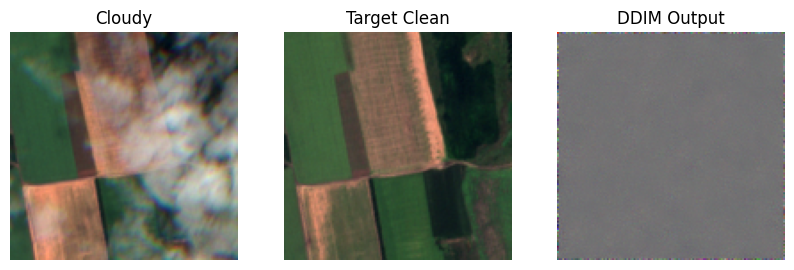

In [63]:
import matplotlib.pyplot as plt

def to_vis(img):  # img: (4,H,W) or (C,H,W)
    # take first 3 channels as RGB-ish
    x = img[:3].detach().cpu().numpy()
    x = x.transpose(1,2,0)  # (H,W,C)
    x = x - x.min()
    x = x / (x.max() + 1e-6)
    return x

i = 0
cloudy_vis = to_vis(cloudy[i])
clean_vis  = to_vis(batch["clean"][i])
x0_vis     = to_vis(x0[i])

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.title("Cloudy"); plt.imshow(cloudy_vis); plt.axis("off")
plt.subplot(1,3,2); plt.title("Target Clean"); plt.imshow(clean_vis); plt.axis("off")
plt.subplot(1,3,3); plt.title("DDIM Output"); plt.imshow(x0_vis); plt.axis("off")
plt.show()


In [68]:
@torch.no_grad()
def inspect_forward_process(clean, cloudy, forwarder, num_steps=10):
    """
    Inspect several intermediate timesteps in the *forward* process.
    
    Returns a dict:
        {
            'x_t_list': [...],     # noisy images
            'eps_list': [...],     # ground-truth noise
            'mu_t_list': [...],    # clean/cloudy mixture without noise
            't_list': [...]
        }
    """
    device = clean.device
    B, C, H, W = clean.shape

    out = {
        "x_t_list": [],
        "eps_list": [],
        "mu_t_list": [],
        "t_list": []
    }

    # Pick evenly spaced timesteps
    T = forwarder.T
    t_values = torch.linspace(0, T-1, num_steps, device=device).long()

    for t in t_values:
        t_batch = t.expand(B)

        x_t, eps, mu_t = forwarder(clean, cloudy, t_batch)

        out["x_t_list"].append(x_t)
        out["eps_list"].append(eps)
        out["mu_t_list"].append(mu_t)
        out["t_list"].append(int(t.item()))

    return out


In [81]:
batch = next(iter(train_loader))
clean  = batch["clean"].to(device)
cloudy = batch["cloudy"].to(device)

forwarder = ForwardDiffusion(T=750).to(device)
forward_info = inspect_forward_process(clean, cloudy, forwarder, num_steps=8)

for i, t in enumerate(forward_info["t_list"]):
    print(f"t = {t}")
    print("  mean(abs(x_t)) =", forward_info["x_t_list"][i].abs().mean().item())
    print("  mean(abs(mu_t)) =", forward_info["mu_t_list"][i].abs().mean().item())


t = 0
  mean(abs(x_t)) = 0.6458654999732971
torch.Size([16, 4, 128, 128])


ValueError: axes don't match array

In [74]:
@torch.no_grad()
def inspect_reverse_process(
    cloudy, cloud_encoder, denoiser, forwarder, num_steps=50
):
    """
    Step-by-step reverse DDIM inspection.
    Returns all intermediate:
        x_t
        eps_pred
        mu_t
        mu_prev
    """
    device = cloudy.device
    B, C, H, W = cloudy.shape

    sigmas = forwarder.sigmas
    lambdas = forwarder.lambdas
    T = forwarder.T

    # time schedule
    step_indices = torch.linspace(T - 1, 0, num_steps, device=device).long()

    out = {
        "x_t_list": [],
        "eps_pred_list": [],
        "mu_t_list": [],
        "mu_prev_list": [],
        "t_list": []
    }

    # initial noisy state
    t0 = step_indices[0]
    sigma0 = sigmas[t0].view(1,1,1,1)
    x_t = cloudy + sigma0 * torch.randn_like(cloudy)

    z_cloud = cloud_encoder(cloudy)

    for i in range(num_steps - 1):
        t = step_indices[i]
        t_next = step_indices[i+1]

        t_batch = t.expand(B)

        sigma_t = sigmas[t].view(1,1,1,1)
        sigma_next = sigmas[t_next].view(1,1,1,1)

        lambda_t = lambdas[t].view(1,1,1,1)
        lambda_next = lambdas[t_next].view(1,1,1,1)

        # ---- predict noise
        eps_pred = denoiser(x_t, t_batch, z_cloud)

        # ---- estimate mu_t
        mu_t = x_t - sigma_t * eps_pred

        # ---- estimate mu_{t-1}
        scale = (1 - lambda_next) / (1 - lambda_t + 1e-6)
        mu_prev = cloudy + (mu_t - cloudy) * scale

        # ---- next x
        x_next = mu_prev + sigma_next * eps_pred

        # store
        out["x_t_list"].append(x_t)
        out["eps_pred_list"].append(eps_pred)
        out["mu_t_list"].append(mu_t)
        out["mu_prev_list"].append(mu_prev)
        out["t_list"].append(int(t.item()))

        x_t = x_next

    out["x_t_list"].append(x_t)  # final result
    out["t_list"].append(0)

    return out


In [75]:
cloudy = batch["cloudy"].to(device)

reverse_info = inspect_reverse_process(
    cloudy,
    cloud_encoder,
    denoiser,
    forwarder,
    num_steps=30
)

for i, t in enumerate(reverse_info["t_list"][:8]):
    print(f"[reverse] t = {t}")
    print("  eps_pred mean =", reverse_info["eps_pred_list"][i].mean().item())
    print("  mu_t       mean =", reverse_info["mu_t_list"][i].mean().item())
    print("  x_t        mean =", reverse_info["x_t_list"][i].mean().item())


[reverse] t = 749
  eps_pred mean = 0.015912873670458794
  mu_t       mean = -0.16258323192596436
  x_t        mean = -0.15621809661388397
[reverse] t = 723
  eps_pred mean = -74.13572692871094
  mu_t       mean = -213.439697265625
  x_t        mean = -242.09033203125
[reverse] t = 697
  eps_pred mean = -140.98043823242188
  mu_t       mean = -401.78314208984375
  x_t        mean = -454.3580322265625
[reverse] t = 671
  eps_pred mean = -204.51080322265625
  mu_t       mean = -579.7564086914062
  x_t        mean = -653.2547607421875
[reverse] t = 645
  eps_pred mean = -265.939453125
  mu_t       mean = -751.7045288085938
  x_t        mean = -843.678955078125
[reverse] t = 619
  eps_pred mean = -325.8416442871094
  mu_t       mean = -919.6787719726562
  x_t        mean = -1027.95947265625
[reverse] t = 594
  eps_pred mean = -382.30572509765625
  mu_t       mean = -1078.4755859375
  x_t        mean = -1200.5426025390625
[reverse] t = 568
  eps_pred mean = -440.0873107910156
  mu_t       m